In [1]:
from bounds import bounds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

In [ ]:
"""
line name: NES170K07Line2, number of batches: 13081
line name: NES170K07Line1, number of batches: 7447
line name: NES170I08Line1, number of batches: 11319
line name: NES2060C05Line2, number of batches: 2348
line name: NES2060C06Line2, number of batches: 3192
line name: NES3105A07Line1, number of batches: 8435
line name: NES3105A07Line2, number of batches: 8187
"""

In [2]:
file_name = "DataOn2025Jan08.xlsx"
df = pd.read_excel(file_name, sheet_name="NES170I08Line1")
df.shape

(11319, 52)

In [3]:
t5_lb = bounds["170I"][0]
t5_ub = bounds["170I"][1]

t5_lb, t5_ub

(5.5, 9.5)

In [4]:
def safe_literal_eval(value):
    """Handle NaN values before using ast.literal_eval"""
    if isinstance(value, str):
        value = value.replace("nan", "None")  # Replace 'nan' with None
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None  # Return None if it cannot be evaluated

def S1_S2_calc(S1, S2):
    S1_S2 = []
    for i in range(1, len(S1)):
        if S2[i] == 0.0:
            S1_S2.append(None)
        else:
            S1_S2.append(S1[i] / S2[i])
    return S1_S2

def organized_data(df, t5_lb, t5_ub):
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):  # Skip processing if t5 is NaN
            continue

        batch_number = row["batch_number"]
        data[batch_number] = {
            "MDR": -1,
            "t5": -1,
            "class": -1
            }
        
        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])

        if t_S1 is not None and t_S2 is not None:
            t, S1 = zip(*t_S1)
            t, S2 = zip(*t_S2)
            t, S1, S2, S1_S2 = list(t), list(S1), list(S2), S1_S2_calc(S1, S2)
            MDR = pd.DataFrame({
                                "time": list(t)[1:], # Exclude first element
                                "S1": list(S1)[1:], # Exclude first element
                                "S2": list(S2)[1:], # Exclude first element
                                "S1_S2": S1_S2_calc(S1, S2)
                            })
            
            #MDR.ffill().bfill() #interpolate(method="linear", inplace=True) # Interpolating NaN values
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)  # Fill remaining NaNs by backfilling
            MDR.fillna(method="ffill", inplace=True)  # Fill remaining NaNs by forward-filling
        
        data[batch_number]["MDR"] = MDR
        data[batch_number]["t5"] = row["t5"]

        if data[batch_number]["t5"]<t5_lb:
            data[batch_number]["class"] = "low"

        elif data[batch_number]["t5"]>t5_ub:
            data[batch_number]["class"] = "high"

        elif data[batch_number]["t5"]>=t5_lb and data[batch_number]["t5"]<=t5_ub:
            data[batch_number]["class"] = "normal"
    
    data = {k: v for k, v in data.items() if not v["MDR"].empty}
    return data

data = organized_data(df, t5_lb, t5_ub)

In [5]:
# print the number of data points for each class of low, high and normal
print(f'# low: {len({k:v for k, v in data.items() if v["class"]=="low"})}')
print(f'# high: {len({k:v for k, v in data.items() if v["class"]=="high"})}')
print(f'# normal: {len({k:v for k, v in data.items() if v["class"]=="normal"})}')

# low: 71
# high: 17
# normal: 5569


In [6]:
def iPlotCooperStandard(data, ID):
    t = data[ID]["MDR"]["time"]
    S1 = data[ID]["MDR"]["S1"]
    S2 = data[ID]["MDR"]["S2"]
    S1_S2 = data[ID]["MDR"]["S1_S2"]

    plt.figure(figsize=(8, 5))
    plt.plot(t, S1, color='blue', label=r'$S_1$')
    plt.plot(t, S2, color='red', label=r'$S_2$')
    plt.plot(t, S1_S2, color='black', label=r'$S_1/S_2$')

    plt.xlabel('time')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

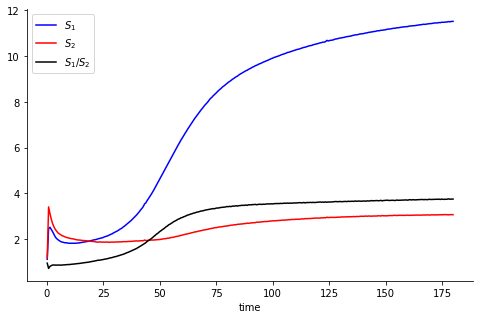

In [8]:
ID = 4104895
iPlotCooperStandard(data, ID)

In [7]:
lens = [v["MDR"].shape[0] for v in data.values()]
max_len = max(lens)

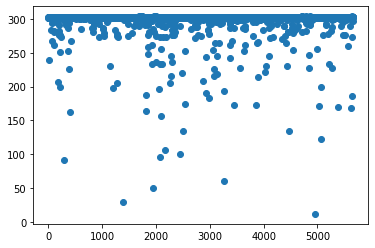

In [8]:
plt.scatter(np.arange(len(lens)), lens)

In [9]:
def len_condition(data, len_threshold):

    data = {k:v for k, v in data.items() if v["MDR"].shape[0]>=len_threshold}

    return data

data = len_condition(data, 290)

In [10]:
t5_list = [v['t5'] for v in data.values()]

print(min(t5_list))
print(max(t5_list))

0.0
16.42


In [11]:
len(data)

5494

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_sequences(data_dict, max_len):
    """
    Process data dictionary into padded sequences and targets
    Returns:
        X: Padded and normalized sequences (n_samples, max_len, 3)
        y: Array of t5 values
        scalers: List of fitted StandardScalers for each feature
    """
    sequences = []
    targets = []
    
    # Extract sequences and targets from dictionary
    for id in data_dict:
        df = data_dict[id]["MDR"]
        # Extract features (excluding time column)
        seq = df[['S1', 'S2', 'S1_S2']].values
        sequences.append(seq.astype('float32'))
        targets.append(data_dict[id]["t5"])
    
    # Filter empty sequences
    non_empty = [s for s in sequences if len(s) > 0]
    filtered_targets = [t for s, t in zip(sequences, targets) if len(s) > 0]
    
    # Pad sequences
    padded_sequences = pad_sequences(
        non_empty,
        maxlen=max_len,
        dtype='float32',
        padding='post',
        truncating='post'
    )
    
    # Normalize features
    scalers = []
    normalized = []
    for feature_idx in range(padded_sequences.shape[2]):
        feature_data = padded_sequences[:, :, feature_idx].reshape(-1, 1)
        scaler = StandardScaler().fit(feature_data)
        scalers.append(scaler)
        normalized_feature = scaler.transform(feature_data).reshape(
            padded_sequences.shape[0], padded_sequences.shape[1], 1)
        normalized.append(normalized_feature)
    
    return np.concatenate(normalized, axis=2), np.array(filtered_targets), scalers

def create_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# RUN:
X, y, scalers = prepare_sequences(data, max_len)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    epochs=10,
    #batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

2025-02-12 00:12:46.177189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-12 00:12:46.177222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-12 00:12:53.975001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-02-12 00:12:53.975039: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-12 00:12:53.975067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2025-02-12 00:12:53.975380: I tensorflow/core/platform/cpu_feature_gua

Epoch 1/10
110/110 [==============================] - 71s 541ms/step - loss: 23.2880 - mae: 4.1903 - val_loss: 0.8356 - val_mae: 0.7113
Epoch 2/10
110/110 [==============================] - 56s 508ms/step - loss: 1.8918 - mae: 1.0192 - val_loss: 0.6220 - val_mae: 0.6207
Epoch 3/10
110/110 [==============================] - 56s 505ms/step - loss: 1.6227 - mae: 0.9873 - val_loss: 0.6139 - val_mae: 0.6159
Epoch 4/10
110/110 [==============================] - 55s 504ms/step - loss: 1.4553 - mae: 0.9317 - val_loss: 0.6362 - val_mae: 0.6280
Epoch 5/10
110/110 [==============================] - 56s 509ms/step - loss: 1.4021 - mae: 0.9232 - val_loss: 0.6402 - val_mae: 0.6301
Epoch 6/10
110/110 [==============================] - 56s 505ms/step - loss: 1.3165 - mae: 0.8993 - val_loss: 0.6273 - val_mae: 0.6229
Epoch 7/10
110/110 [==============================] - 56s 512ms/step - loss: 1.3050 - mae: 0.8950 - val_loss: 0.6083 - val_mae: 0.6130
Epoch 8/10
110/110 [==============================] - 

In [ ]:
def predict_t5(model, scalers, new_data_dict, max_len=305):
    processed = []
    for id in new_data_dict:
        seq = new_data_dict[id]["df"][['S1', 'S2', 'S1_S2']].values
        padded = pad_sequences([seq], maxlen=max_len, padding='post', truncating='post')
        
        # Normalize using existing scalers
        normalized = []
        for feature_idx in range(3):
            feature_data = padded[:, :, feature_idx].reshape(-1, 1)
            normalized_feature = scalers[feature_idx].transform(feature_data)
            normalized.append(normalized_feature.reshape(padded.shape[0], max_len, 1))
            
        processed.append(np.concatenate(normalized, axis=2))
    
    return model.predict(np.concatenate(processed))

**Handling the unbalanced dataset**

(20528, 43)
# low: 365
# high: 677
# normal: 7300


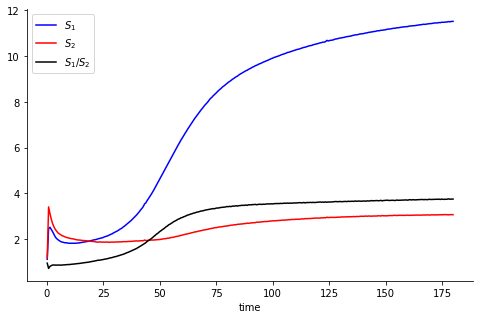

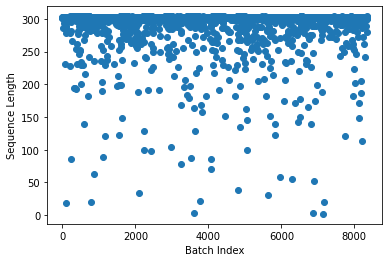

t5 range: 4.58 14.1
Number of batches: 7955
Training class counts: Counter({'normal': 5581, 'high': 504, 'low': 279})
Epoch 1/10
160/160 [==============================] - 93s 506ms/step - loss: 17.7465 - mae: 3.0737 - val_loss: 1.3613 - val_mae: 0.5055
Epoch 2/10
160/160 [==============================] - 81s 506ms/step - loss: 2.4964 - mae: 0.9686 - val_loss: 1.3748 - val_mae: 0.5507
Epoch 3/10
160/160 [==============================] - 79s 493ms/step - loss: 2.4465 - mae: 0.9784 - val_loss: 1.3334 - val_mae: 0.5223
Epoch 4/10
160/160 [==============================] - 79s 495ms/step - loss: 2.2373 - mae: 0.9315 - val_loss: 1.3242 - val_mae: 0.5078
Epoch 5/10
160/160 [==============================] - 80s 503ms/step - loss: 2.4219 - mae: 0.9376 - val_loss: 1.3338 - val_mae: 0.5256
Epoch 6/10
160/160 [==============================] - 79s 494ms/step - loss: 2.2731 - mae: 0.9104 - val_loss: 1.3473 - val_mae: 0.5412
Epoch 7/10
160/160 [==============================] - 79s 495ms/step - 

In [18]:
# %%
from bounds import bounds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# %%
"""
line name: NES170K07Line2, number of batches: 13081
line name: NES170K07Line1, number of batches: 7447
line name: NES170I08Line1, number of batches: 11319
line name: NES2060C05Line2, number of batches: 2348
line name: NES2060C06Line2, number of batches: 3192
line name: NES3105A07Line1, number of batches: 8435
line name: NES3105A07Line2, number of batches: 8187
"""

# %%
file_name = "DataOn2025Jan08.xlsx"
df1 = pd.read_excel(file_name, sheet_name="NES170K07Line2")
df2 = pd.read_excel(file_name, sheet_name="NES170K07Line1")

df = pd.concat([df1, df2], ignore_index=True)
print(df.shape)

# %%
t5_lb = bounds["170K"][0]
t5_ub = bounds["170K"][1]

# %%
def safe_literal_eval(value):
    """Handle NaN values before using ast.literal_eval"""
    if isinstance(value, str):
        value = value.replace("nan", "None")  # Replace 'nan' with None
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None  # Return None if it cannot be evaluated

def S1_S2_calc(S1, S2):
    S1_S2 = []
    for i in range(1, len(S1)):
        if S2[i] == 0.0:
            S1_S2.append(None)
        else:
            S1_S2.append(S1[i] / S2[i])
    return S1_S2

def organized_data(df, t5_lb, t5_ub):
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):  # Skip processing if t5 is NaN
            continue

        batch_number = row["batch_number"]
        data[batch_number] = {
            "MDR": -1,
            "t5": -1,
            "class": -1
        }
        
        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])

        if t_S1 is not None and t_S2 is not None:
            t, S1 = zip(*t_S1)
            t, S2 = zip(*t_S2)
            t, S1, S2 = list(t), list(S1), list(S2)
            S1_S2 = S1_S2_calc(S1, S2)
            MDR = pd.DataFrame({
                "time": t[1:],  # Exclude first element
                "S1": S1[1:],   # Exclude first element
                "S2": S2[1:],   # Exclude first element
                "S1_S2": S1_S2
            })
            
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)
            MDR.fillna(method="ffill", inplace=True)
        
        data[batch_number]["MDR"] = MDR
        data[batch_number]["t5"] = row["t5"]

        if data[batch_number]["t5"] < t5_lb:
            data[batch_number]["class"] = "low"
        elif data[batch_number]["t5"] > t5_ub:
            data[batch_number]["class"] = "high"
        else:
            data[batch_number]["class"] = "normal"
    
    # Remove entries with empty MDR DataFrame
    data = {k: v for k, v in data.items() if not v["MDR"].empty}
    return data

data = organized_data(df, t5_lb, t5_ub)

# %%
# Print the number of data points for each class
print(f'# low: {len({k: v for k, v in data.items() if v["class"]=="low"})}')
print(f'# high: {len({k: v for k, v in data.items() if v["class"]=="high"})}')
print(f'# normal: {len({k: v for k, v in data.items() if v["class"]=="normal"})}')

# %%
def iPlotCooperStandard(data, ID):
    t = data[ID]["MDR"]["time"]
    S1 = data[ID]["MDR"]["S1"]
    S2 = data[ID]["MDR"]["S2"]
    S1_S2 = data[ID]["MDR"]["S1_S2"]

    plt.figure(figsize=(8, 5))
    plt.plot(t, S1, color='blue', label=r'$S_1$')
    plt.plot(t, S2, color='red', label=r'$S_2$')
    plt.plot(t, S1_S2, color='black', label=r'$S_1/S_2$')

    plt.xlabel('time')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

# %%
ID = 4104895
iPlotCooperStandard(data, ID)

# %%
lens = [v["MDR"].shape[0] for v in data.values()]
max_len = max(lens)
plt.scatter(np.arange(len(lens)), lens)
plt.xlabel("Batch Index")
plt.ylabel("Sequence Length")
plt.show()

# %%
def len_condition(data, len_threshold):
    data = {k: v for k, v in data.items() if v["MDR"].shape[0] >= len_threshold}
    return data

data = len_condition(data, 290)

# %%
t5_list = [v['t5'] for v in data.values()]
print("t5 range:", min(t5_list), max(t5_list))
print("Number of batches:", len(data))

# %%
def prepare_sequences(data_dict, max_len=305):
    """
    Process data dictionary into padded sequences, targets, and classes.
    Returns:
        X: Padded and normalized sequences (n_samples, max_len, 3)
        y: Array of t5 values
        classes: Array of class labels (low, normal, high)
        scalers: List of fitted StandardScalers for each feature
    """
    sequences = []
    targets = []
    classes = []
    
    # Extract sequences, targets, and class labels
    for _id in data_dict:
        df = data_dict[_id]["MDR"]
        seq = df[['S1', 'S2', 'S1_S2']].values.astype('float32')
        sequences.append(seq)
        targets.append(data_dict[_id]["t5"])
        classes.append(data_dict[_id]["class"])
    
    # Filter out any empty sequences (if any)
    non_empty = [s for s in sequences if len(s) > 0]
    filtered_targets = [t for s, t in zip(sequences, targets) if len(s) > 0]
    filtered_classes = [c for s, c in zip(sequences, classes) if len(s) > 0]
    
    # Pad sequences
    padded_sequences = pad_sequences(
        non_empty,
        maxlen=max_len,
        dtype='float32',
        padding='post',
        truncating='post'
    )
    
    # Normalize features feature-wise using StandardScaler
    scalers = []
    normalized = []
    for feature_idx in range(padded_sequences.shape[2]):
        feature_data = padded_sequences[:, :, feature_idx].reshape(-1, 1)
        scaler = StandardScaler().fit(feature_data)
        scalers.append(scaler)
        normalized_feature = scaler.transform(feature_data).reshape(
            padded_sequences.shape[0], padded_sequences.shape[1], 1)
        normalized.append(normalized_feature)
    
    X = np.concatenate(normalized, axis=2)
    return X, np.array(filtered_targets), np.array(filtered_classes), scalers

# %%
X, y, classes, scalers = prepare_sequences(data)
# Using stratification here can help keep class proportions in train and test sets.
X_train, X_test, y_train, y_test, classes_train, classes_test = train_test_split(
    X, y, classes, test_size=0.2, random_state=42, stratify=classes
)

# %%
def create_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

model = create_lstm_model((X_train.shape[1], X_train.shape[2]))

# %%
# Compute sample weights to address class imbalance.
# We'll assign a weight to each training sample inversely proportional to its class frequency.
train_class_counts = Counter(classes_train)
total_train_samples = len(classes_train)
num_classes = len(train_class_counts)
print("Training class counts:", train_class_counts)

# Weight for a sample = total_samples / (num_classes * count_of_its_class)
sample_weights = np.array([
    total_train_samples / (num_classes * train_class_counts[c]) for c in classes_train
])

# %%
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    sample_weight=sample_weights,  # Apply sample weights
    verbose=1
)

# %%
# Evaluate the model on the test set (without sample weighting)
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

# %%
def predict_t5(model, scalers, new_data_dict, max_len=305):
    processed = []
    for _id in new_data_dict:
        seq = new_data_dict[_id]["df"][['S1', 'S2', 'S1_S2']].values.astype('float32')
        padded = pad_sequences([seq], maxlen=max_len, padding='post', truncating='post')
        
        # Normalize using existing scalers
        normalized = []
        for feature_idx in range(3):
            feature_data = padded[:, :, feature_idx].reshape(-1, 1)
            normalized_feature = scalers[feature_idx].transform(feature_data)
            normalized.append(normalized_feature.reshape(padded.shape[0], max_len, 1))
            
        processed.append(np.concatenate(normalized, axis=2))
    
    return model.predict(np.concatenate(processed))


In [19]:

# Evaluate model on the test set (without sample weighting)
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Overall Test MAE: {test_mae:.4f}")

# -----------------------
# Additional Evaluation: Compute per-class MAE on the test set

# Get predictions for the test set and flatten to a 1D array
predictions = model.predict(X_test).flatten()

# Convert classes_test to a numpy array (if not already)
classes_test = np.array(classes_test)

# Compute and print MAE for each class separately
unique_classes = np.unique(classes_test)
for cls in unique_classes:
    # Find indices for samples belonging to the current class
    indices = np.where(classes_test == cls)[0]
    # Compute MAE for these samples
    class_mae = np.mean(np.abs(y_test[indices] - predictions[indices]))
    print(f"Test MAE for class '{cls}': {class_mae:.4f}")


50/50 [==============================] - 6s 112ms/step - loss: 0.5316 - mae: 0.5704
Overall Test MAE: 0.5704
Test MAE for class 'high': 1.5822
Test MAE for class 'low': 1.0952
Test MAE for class 'normal': 0.4527


In [20]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import bounds dictionary (ensure you have bounds.py in your working directory)
from bounds import bounds

# ---------------------------
# Data Preprocessing Functions
# ---------------------------
def safe_literal_eval(value):
    """Safely evaluates a string representation of a Python literal."""
    if isinstance(value, str):
        value = value.replace("nan", "None")
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

def S1_S2_calc(S1, S2):
    """Calculate the element-wise ratio of S1 to S2, skipping the first element."""
    S1_S2 = []
    for i in range(1, len(S1)):
        if S2[i] == 0.0:
            S1_S2.append(None)
        else:
            S1_S2.append(S1[i] / S2[i])
    return S1_S2

def organized_data(df, t5_lb, t5_ub):
    """Organize the DataFrame into a dictionary with batch data and class labels."""
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):
            continue
        batch_number = row["batch_number"]
        data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}
        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])

        if t_S1 is not None and t_S2 is not None:
            t, S1 = zip(*t_S1)
            t, S2 = zip(*t_S2)
            t, S1, S2 = list(t), list(S1), list(S2)
            S1_S2 = S1_S2_calc(S1, S2)
            MDR = pd.DataFrame({
                "time": t[1:],   # Skip first element
                "S1": S1[1:],
                "S2": S2[1:],
                "S1_S2": S1_S2
            })
            # Interpolate and fill missing values
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)
            MDR.fillna(method="ffill", inplace=True)
        else:
            continue  # Skip if parsing failed

        data[batch_number]["MDR"] = MDR

        # Classify based on t5 value and the provided bounds
        if row["t5"] < t5_lb:
            data[batch_number]["class"] = "low"
        elif row["t5"] > t5_ub:
            data[batch_number]["class"] = "high"
        else:
            data[batch_number]["class"] = "normal"
    
    # Remove any batches with empty MDR data
    data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
    return data

def len_condition(data, len_threshold):
    """Keep only those batches whose MDR DataFrame has at least len_threshold rows."""
    return {k: v for k, v in data.items() if v["MDR"].shape[0] >= len_threshold}

def prepare_sequences(data_dict, max_len=305):
    """
    Process the data dictionary into padded, normalized sequences,
    along with target t5 values and class labels.
    """
    sequences = []
    targets = []
    classes = []
    for _id in data_dict:
        df = data_dict[_id]["MDR"]
        seq = df[["S1", "S2", "S1_S2"]].values.astype("float32")
        sequences.append(seq)
        targets.append(data_dict[_id]["t5"])
        classes.append(data_dict[_id]["class"])
    
    # Filter out any empty sequences (if any)
    non_empty = [s for s in sequences if len(s) > 0]
    filtered_targets = [t for s, t in zip(sequences, targets) if len(s) > 0]
    filtered_classes = [c for s, c in zip(sequences, classes) if len(s) > 0]
    
    # Pad sequences to a fixed length
    padded_sequences = pad_sequences(
        non_empty,
        maxlen=max_len,
        dtype="float32",
        padding="post",
        truncating="post"
    )
    
    # Normalize features feature-wise using StandardScaler
    scalers = []
    normalized = []
    for feature_idx in range(padded_sequences.shape[2]):
        feature_data = padded_sequences[:, :, feature_idx].reshape(-1, 1)
        scaler = StandardScaler().fit(feature_data)
        scalers.append(scaler)
        normalized_feature = scaler.transform(feature_data).reshape(
            padded_sequences.shape[0], padded_sequences.shape[1], 1)
        normalized.append(normalized_feature)
    
    X = np.concatenate(normalized, axis=2)
    return X, np.array(filtered_targets), np.array(filtered_classes), scalers

def create_lstm_model(input_shape):
    """Build and compile an LSTM model for regression."""
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def compute_sample_weights(classes, exponent=1.5):
    """Compute sample weights inversely proportional to class frequencies."""
    counts = Counter(classes)
    total = len(classes)
    num_classes = len(counts)
    base_weights = {cls: total / (num_classes * count) for cls, count in counts.items()}
    weights = [base_weights[c] ** exponent for c in classes]
    return np.array(weights)

# ---------------------------
# Main Code
# ---------------------------

# 1. Read the Excel file and concatenate two sheets
file_name = "DataOn2025Jan08.xlsx"
df1 = pd.read_excel(file_name, sheet_name="NES170K07Line2")
df2 = pd.read_excel(file_name, sheet_name="NES170K07Line1")
df = pd.concat([df1, df2], ignore_index=True)
print("Data shape:", df.shape)

# 2. Set bounds for t5 from the imported bounds dictionary
t5_lb = bounds["170K"][0]
t5_ub = bounds["170K"][1]

# 3. Organize the data and print the number of samples per class
data = organized_data(df, t5_lb, t5_ub)
print(f"# low: {len({k: v for k, v in data.items() if v['class']=='low'})}")
print(f"# high: {len({k: v for k, v in data.items() if v['class']=='high'})}")
print(f"# normal: {len({k: v for k, v in data.items() if v['class']=='normal'})}")

# 4. Filter batches by sequence length (e.g., at least 290 time steps)
data = len_condition(data, 290)
t5_list = [v["t5"] for v in data.values()]
print("t5 range:", min(t5_list), max(t5_list))
print("Number of batches after filtering:", len(data))

# 5. Prepare sequences for modeling (padded and normalized)
X, y, classes, scalers = prepare_sequences(data)

# 6. Split into training and testing sets with stratification by class
X_train, X_test, y_train, y_test, classes_train, classes_test = train_test_split(
    X, y, classes, test_size=0.2, random_state=42, stratify=classes
)

# 7. Compute sample weights to help with the unbalanced dataset
sample_weights = compute_sample_weights(classes_train, exponent=1.5)
print("Training class distribution:", Counter(classes_train))

# ---------------------------
# Model Ensembling
# ---------------------------
n_models = 3  # Number of models in the ensemble
ensemble_models = []

for i in range(n_models):
    print(f"\n--- Training ensemble model {i+1}/{n_models} ---")
    tf.keras.backend.clear_session()  # Clear previous model
    tf.random.set_seed(i)  # Set a seed for diversity
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    
    # Train the model with sample weights
    model.fit(
        X_train, y_train,
        epochs=10,
        validation_split=0.2,
        sample_weight=sample_weights,
        verbose=1
    )
    ensemble_models.append(model)

# ---------------------------
# Ensemble Prediction and Evaluation
# ---------------------------
# Get predictions from each model in the ensemble on the test set
preds_list = [model.predict(X_test).flatten() for model in ensemble_models]
# Average the predictions from all ensemble models
ensemble_preds = np.mean(preds_list, axis=0)

# Compute overall MAE for the ensemble predictions
overall_ensemble_mae = np.mean(np.abs(y_test - ensemble_preds))
print(f"\nEnsemble Overall Test MAE: {overall_ensemble_mae:.4f}")

# Compute and print MAE per class on the test set
classes_test = np.array(classes_test)
unique_classes = np.unique(classes_test)
for cls in unique_classes:
    indices = np.where(classes_test == cls)[0]
    class_mae = np.mean(np.abs(y_test[indices] - ensemble_preds[indices]))
    print(f"Ensemble Test MAE for class '{cls}': {class_mae:.4f}")


Data shape: (20528, 43)
# low: 365
# high: 677
# normal: 7297
t5 range: 4.58 14.1
Number of batches after filtering: 7952
Training class distribution: Counter({'normal': 5578, 'high': 504, 'low': 279})

--- Training ensemble model 1/3 ---
Epoch 1/10
159/159 [==============================] - 66s 365ms/step - loss: 37.6490 - mae: 3.6492 - val_loss: 3.0338 - val_mae: 0.5197
Epoch 2/10
159/159 [==============================] - 54s 341ms/step - loss: 5.3784 - mae: 1.0524 - val_loss: 3.0135 - val_mae: 0.5178
Epoch 3/10
159/159 [==============================] - 54s 340ms/step - loss: 4.9009 - mae: 0.9887 - val_loss: 3.1414 - val_mae: 0.7378
Epoch 4/10
159/159 [==============================] - 54s 340ms/step - loss: 5.0888 - mae: 1.0120 - val_loss: 2.9602 - val_mae: 0.5896
Epoch 5/10
159/159 [==============================] - 54s 339ms/step - loss: 5.1943 - mae: 0.9720 - val_loss: 2.9504 - val_mae: 0.5868
Epoch 6/10
159/159 [==============================] - 55s 343ms/step - loss: 4.6271 -